Ejecutando en Python 3.9.6 (default, Apr 30 2025, 02:07:17) 
[Clang 17.0.0 (clang-1700.0.13.5)]
Verificando compatibilidad...
=== ANÁLISIS DE DEFORESTACIÓN - BOSQUE NACIONAL JAMANXIM ===

Extrayendo imágenes del GIF...
Extraídas 20 imágenes únicas del GIF

Mostrando proceso detallado para el año 2019:
Analizando imagen del año 2019...


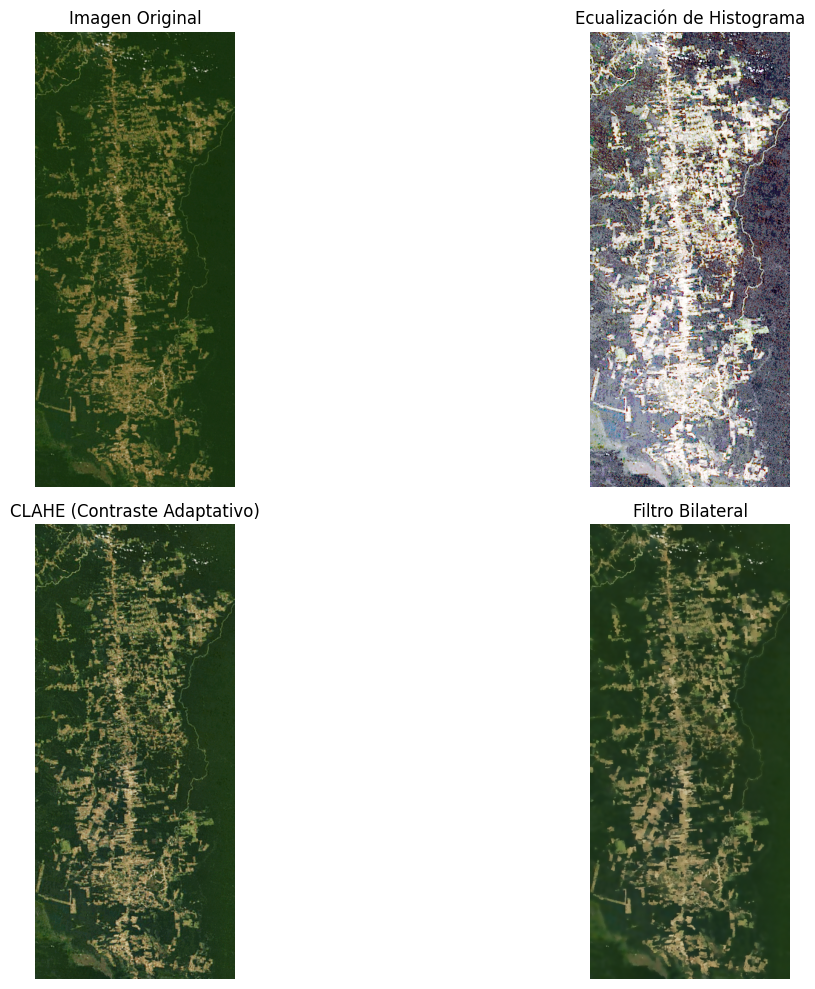

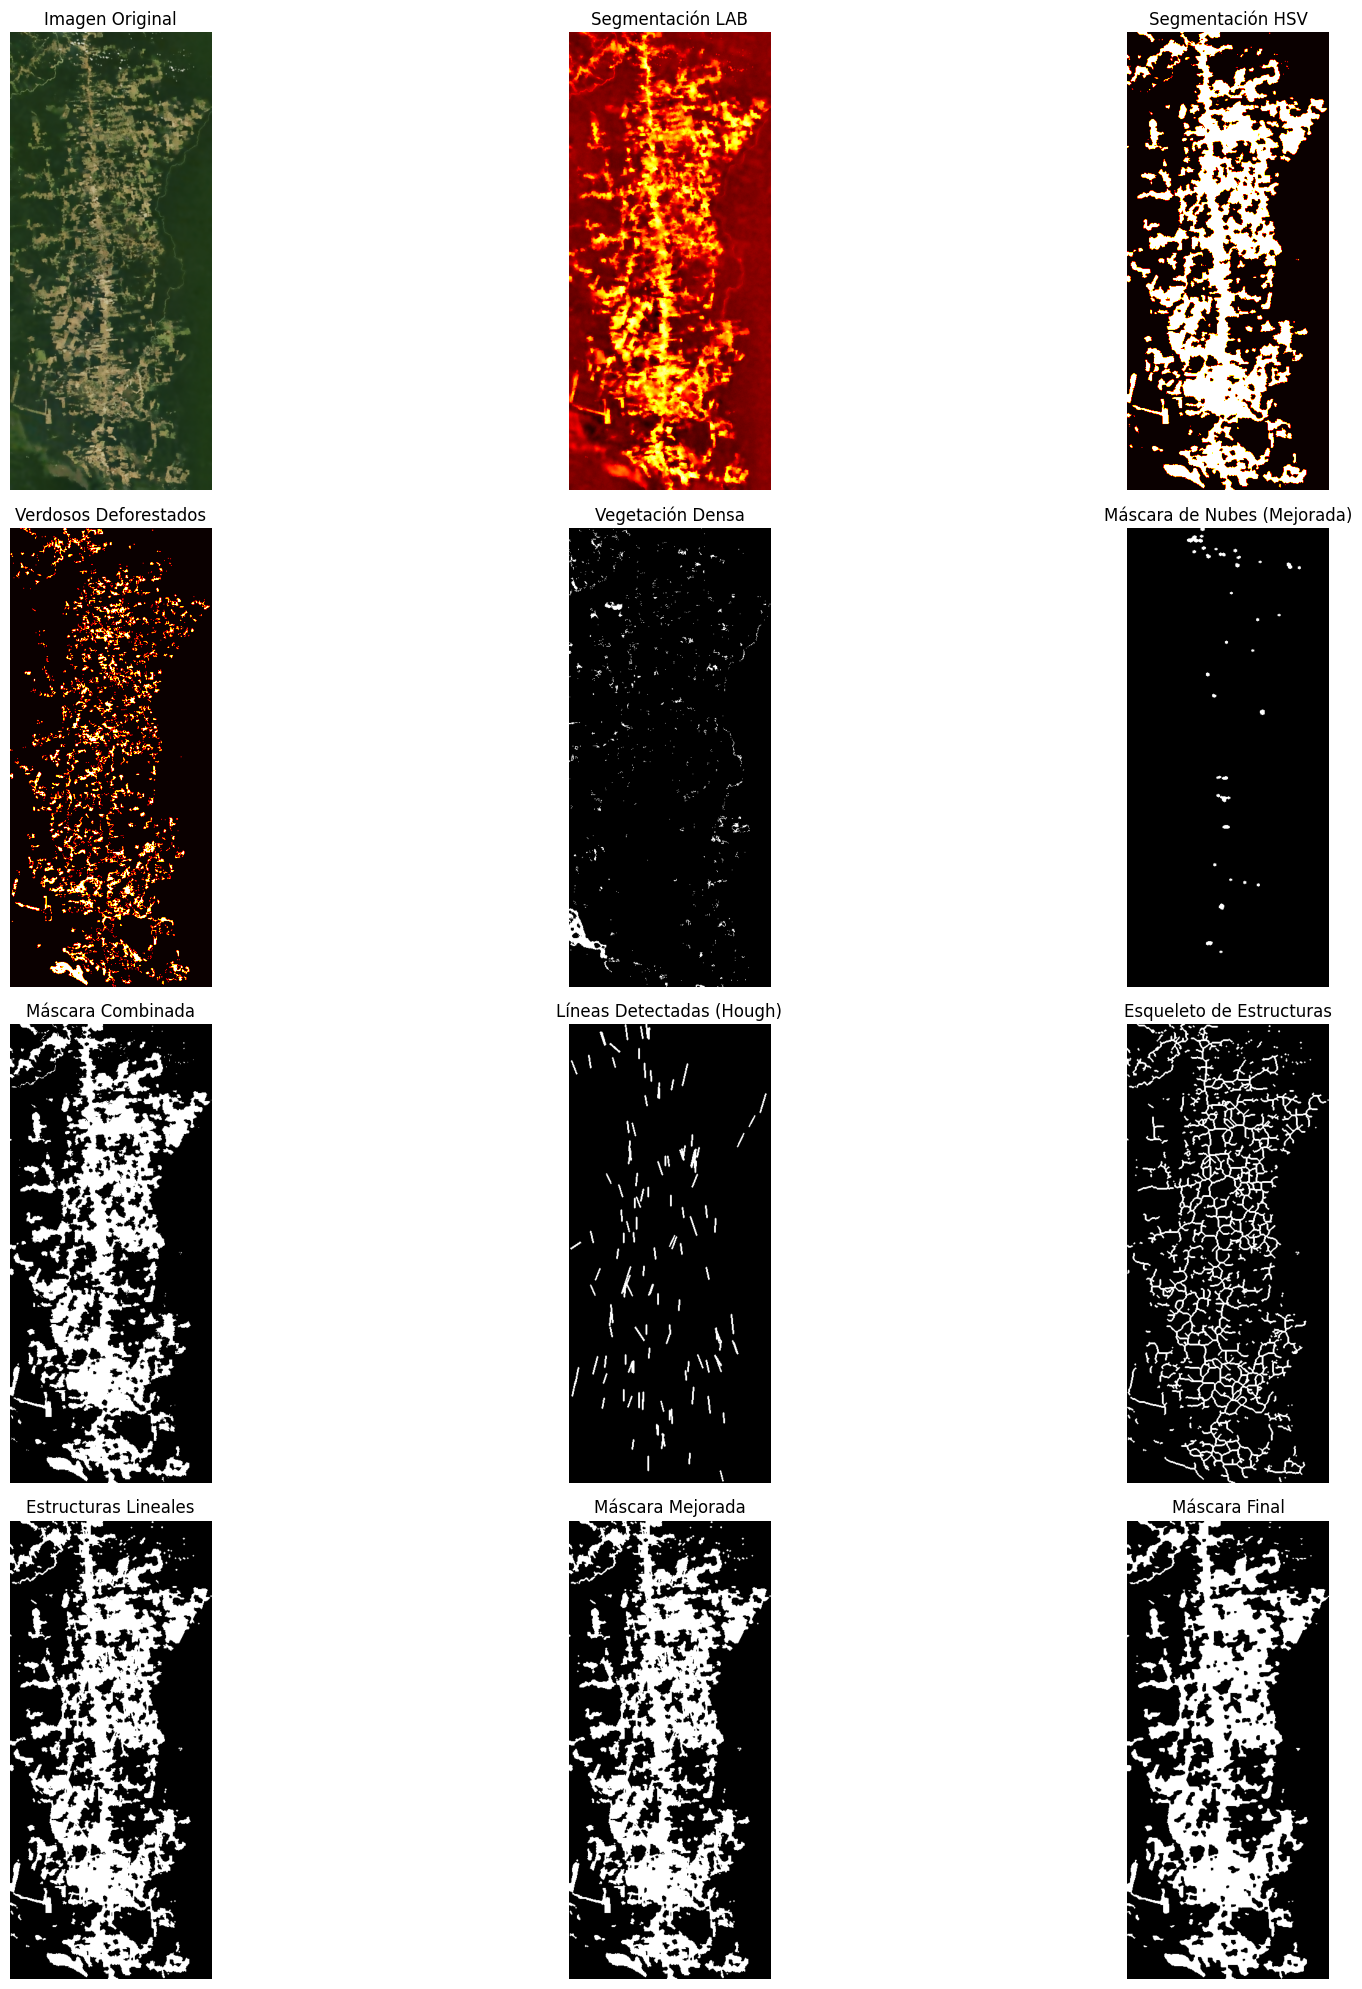

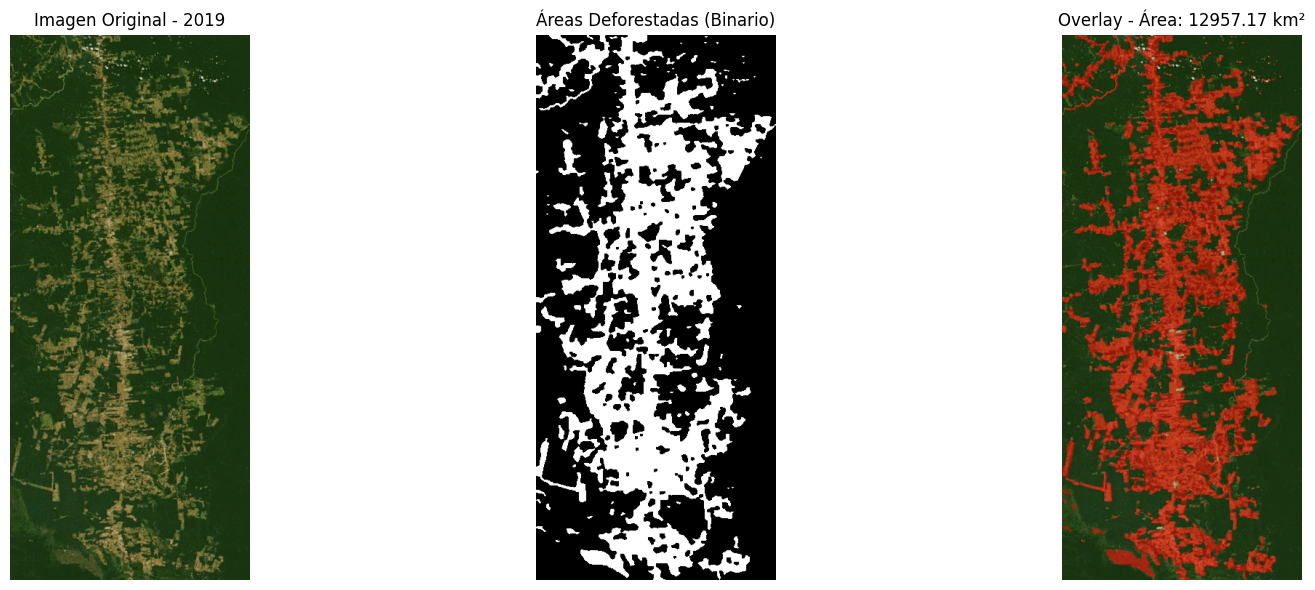

Iniciando análisis completo...
Analizando imagen del año 2000...
Año 2000: 4002.77 km² deforestados
Analizando imagen del año 2001...
Año 2001: 4805.54 km² deforestados
Analizando imagen del año 2002...
Año 2002: 3631.37 km² deforestados
Analizando imagen del año 2003...
Año 2003: 3082.66 km² deforestados
Analizando imagen del año 2004...
Año 2004: 5673.20 km² deforestados
Analizando imagen del año 2005...
Año 2005: 5096.04 km² deforestados
Analizando imagen del año 2006...
Año 2006: 6770.93 km² deforestados
Analizando imagen del año 2007...
Año 2007: 9250.29 km² deforestados
Analizando imagen del año 2008...
Año 2008: 9036.99 km² deforestados
Analizando imagen del año 2009...
Año 2009: 8160.55 km² deforestados
Analizando imagen del año 2010...
Año 2010: 8119.03 km² deforestados
Analizando imagen del año 2011...
Año 2011: 11022.07 km² deforestados
Analizando imagen del año 2012...
Año 2012: 10112.73 km² deforestados
Analizando imagen del año 2013...
Año 2013: 9417.30 km² deforestados
A

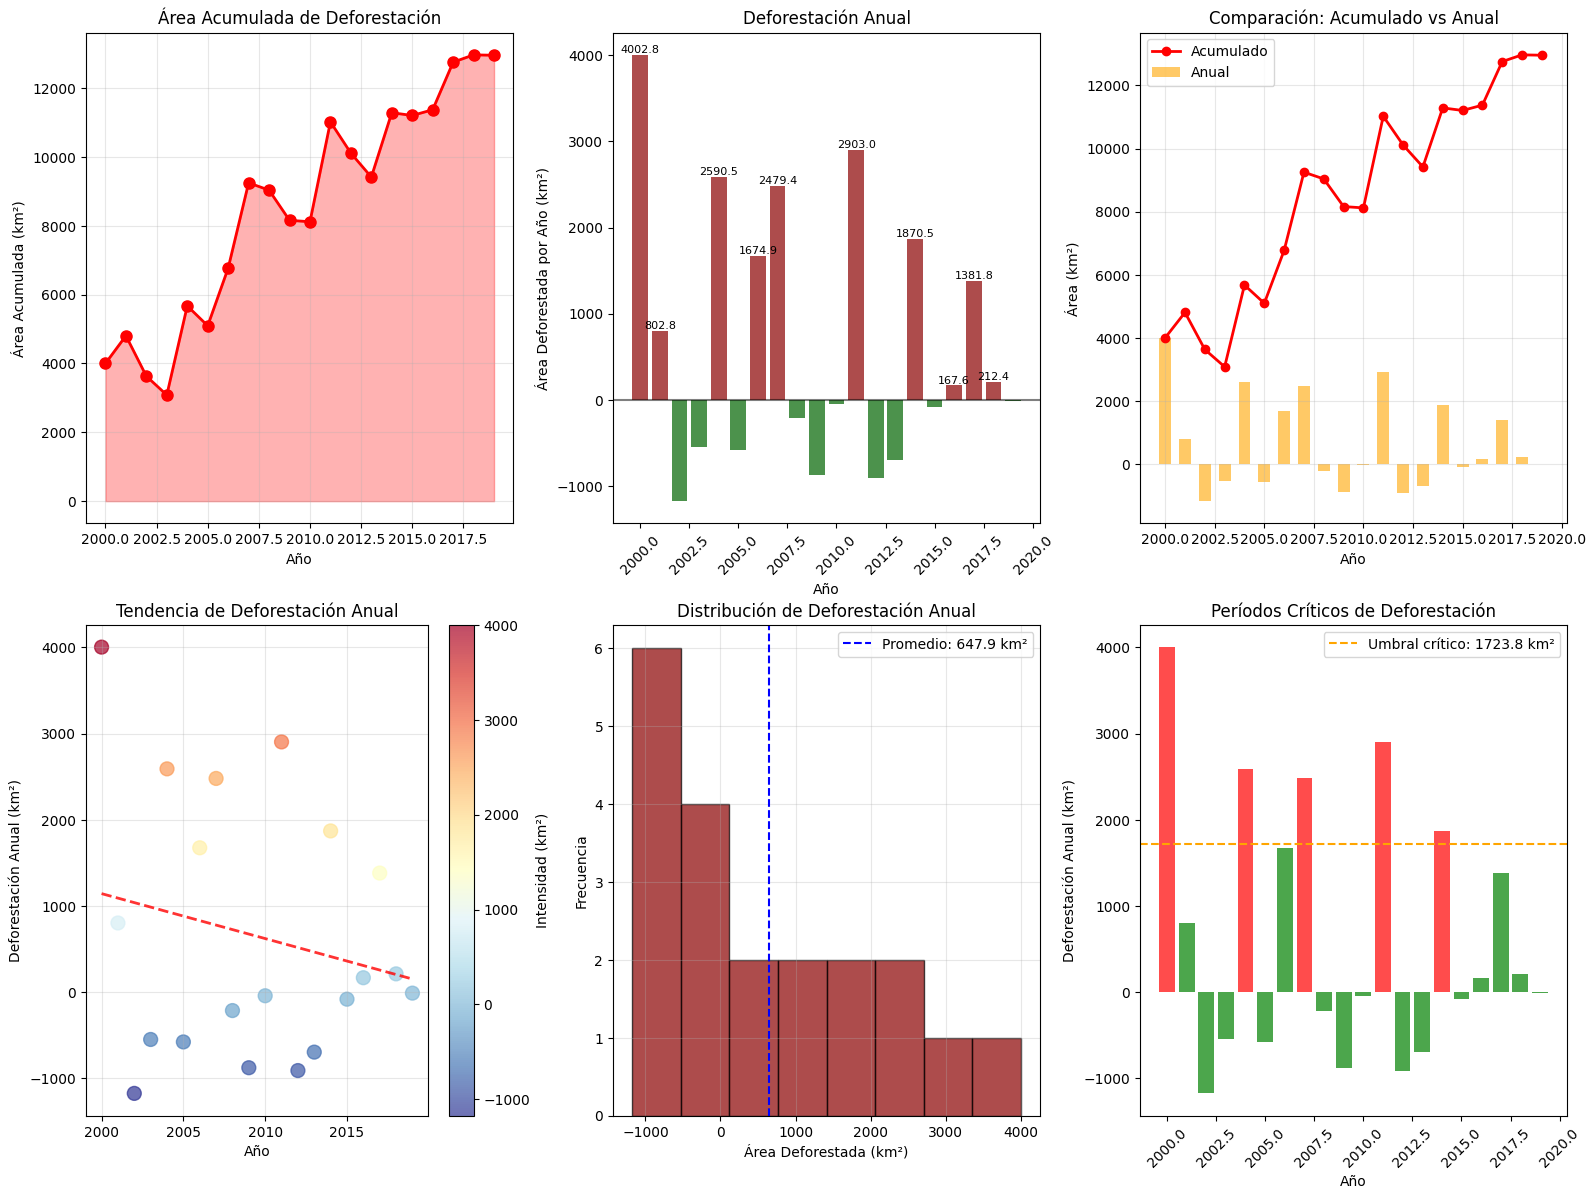


RESUMEN ESTADÍSTICO CORREGIDO

📊 ÁREA ACUMULADA:
   • Área total acumulada al final del período: 12957.17 km²
   • Área inicial (año 2000): 4002.77 km²

🌳 DEFORESTACIÓN ANUAL:
   • Deforestación total en el período: 12957.17 km²
   • Promedio anual: 647.86 ± 1486.61 km²
   • Mediana anual: 78.28 km²

📈 EXTREMOS ANUALES:
   • Año con MAYOR deforestación: 2000 (4002.77 km²)
   • Año con MENOR deforestación: 2002 (-1174.16 km²)

📉 TENDENCIA TEMPORAL:
   • Tendencia: DISMINUCIÓN de 52.15 km²/año

⚠️  PERÍODOS CRÍTICOS (>1723.8 km²/año):
   • Años críticos: 2000, 2004, 2007, 2011, 2014
   • Deforestación promedio en períodos críticos: 2769.24 km²

🔧 NOTA TÉCNICA:
   • Años con valores negativos: 2002, 2003, 2005, 2008, 2009, 2010, 2012, 2013, 2015, 2019
   • Esto puede indicar mejoras necesarias en el algoritmo de detección

💾 Resultados guardados en 'deforestation_analysis_corrected.csv'

Análisis completado. Los resultados están disponibles en 'results_df' y las máscaras en 'masks'


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
from scipy import ndimage
import warnings

# Importaciones con manejo de errores para compatibilidad
try:
    from skimage import filters, morphology, segmentation
    from skimage.color import rgb2lab, rgb2hsv
except ImportError:
    print("Error: Se requiere scikit-image. Instalar con: pip install scikit-image")
    raise

# Suprimir warnings de compatibilidad
warnings.filterwarnings('ignore', category=DeprecationWarning)

class DeforestationAnalyzer:
    def __init__(self, gif_path="deforest.gif"):
        """
        Inicializa el analizador de deforestación
        
        Args:
            gif_path: Ruta al archivo GIF con las imágenes satelitales
        """
        self.gif_path = gif_path
        self.images = []
        self.years = list(range(2000, 2020))  # 2000-2019
        self.km_per_pixel = 20 / 51  # 20 km = 51 píxeles según especificación
        self.debug_year_index = 14  # Año 2005 para mostrar el proceso (editable)
    
    def safe_boolean_operation(self, mask1, mask2, operation='or'):
        """
        Realiza operaciones booleanas de manera segura para compatibilidad
        """
        # Convertir la primera máscara a boolean
        mask1_bool = np.array(mask1, dtype=bool)
        
        if operation == 'not':
            return ~mask1_bool
        
        # Para operaciones binarias, convertir la segunda máscara
        mask2_bool = np.array(mask2, dtype=bool)
        
        if operation == 'or':
            return mask1_bool | mask2_bool
        elif operation == 'and':
            return mask1_bool & mask2_bool
        else:
            raise ValueError("Operación no soportada")
        
    def extract_images_from_gif(self):
        """
        Extrae las imágenes únicas del GIF
        """
        print("Extrayendo imágenes del GIF...")
        
        # Abrir el GIF
        gif = Image.open(self.gif_path)
        
        # Lista para almacenar imágenes únicas
        unique_images = []
        previous_frame = None
        
        frame_index = 0
        try:
            while True:
                # Obtener el frame actual
                current_frame = gif.copy()
                
                # Convertir a array numpy
                frame_array = np.array(current_frame.convert('RGB'))
                
                # Verificar si es diferente al frame anterior
                if previous_frame is None or not np.array_equal(frame_array, previous_frame):
                    unique_images.append(frame_array)
                    previous_frame = frame_array.copy()
                
                # Avanzar al siguiente frame
                gif.seek(frame_index + 1)
                frame_index += 1
                
        except EOFError:
            # Se alcanzó el final del GIF
            pass
        
        self.images = unique_images
        print(f"Extraídas {len(self.images)} imágenes únicas del GIF")
        
        # Ajustar años si el número de imágenes no coincide
        if len(self.images) != 20:
            print(f"Ajustando años: se encontraron {len(self.images)} imágenes")
            self.years = list(range(2000, 2000 + len(self.images)))
        
        return self.images
    
    def preprocess_image(self, image, show_debug=False):
        """
        Preprocesa la imagen aplicando mejoras de contraste y filtros
        
        Args:
            image: Imagen a procesar
            show_debug: Si mostrar los pasos de debug
        """
        # Convertir a float para procesamiento
        img_float = image.astype(np.float32) / 255.0
        
        # 1. Ecualización del histograma por canal
        img_eq = np.zeros_like(img_float)
        for i in range(3):
            img_eq[:,:,i] = cv2.equalizeHist((img_float[:,:,i] * 255).astype(np.uint8)) / 255.0
        
        # 2. Mejora de contraste usando CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_clahe = np.zeros_like(img_float)
        for i in range(3):
            img_clahe[:,:,i] = clahe.apply((img_float[:,:,i] * 255).astype(np.uint8)) / 255.0
        
        # 3. Filtro bilateral para reducir ruido manteniendo bordes
        img_bilateral = cv2.bilateralFilter((img_clahe * 255).astype(np.uint8), 9, 75, 75) / 255.0
        
        if show_debug:
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            axes[0,0].imshow(img_float)
            axes[0,0].set_title('Imagen Original')
            axes[0,0].axis('off')
            
            axes[0,1].imshow(img_eq)
            axes[0,1].set_title('Ecualización de Histograma')
            axes[0,1].axis('off')
            
            axes[1,0].imshow(img_clahe)
            axes[1,0].set_title('CLAHE (Contraste Adaptativo)')
            axes[1,0].axis('off')
            
            axes[1,1].imshow(img_bilateral)
            axes[1,1].set_title('Filtro Bilateral')
            axes[1,1].axis('off')
            
            plt.tight_layout()
            plt.show()
        
        return (img_bilateral * 255).astype(np.uint8)
    
    def detect_clouds_improved(self, image):
        """
        Detección mejorada de nubes, incluyendo nubes semi-opacas
        
        Args:
            image: Imagen en formato RGB
        """
        # Convertir a diferentes espacios de color
        hsv_image = rgb2hsv(image)
        lab_image = rgb2lab(image)
        
        h_channel = hsv_image[:,:,0] * 360
        s_channel = hsv_image[:,:,1]
        v_channel = hsv_image[:,:,2]
        
        l_channel = lab_image[:,:,0]
        a_channel = lab_image[:,:,1]
        b_channel = lab_image[:,:,2]
        
        # 1. Detección básica de nubes blancas intensas
        bright_clouds = (v_channel > 0.85) & (s_channel < 0.15)
        
        # 2. Detección de nubes semi-opacas (blancos menos intensos)
        semi_opaque_clouds = (v_channel > 0.75) & (s_channel < 0.25) & (l_channel > 75)
        
        # 3. Detección usando canal L en LAB (luminancia alta)
        high_luminance = l_channel > 80
        
        # 4. Detección de nubes grisáceas claras
        gray_clouds = (v_channel > 0.65) & (s_channel < 0.35) & \
                     (abs(a_channel) < 5) & (abs(b_channel) < 5)
        
        # 5. Detección usando gradiente (nubes tienen bordes suaves)
        gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gradient = cv2.Laplacian(gray_img, cv2.CV_64F)
        low_gradient = np.abs(gradient) < 10  # Áreas con poco contraste interno
        
        # Combinar detecciones de nubes
        cloud_mask_1 = self.safe_boolean_operation(bright_clouds, semi_opaque_clouds, 'or')
        cloud_mask_2 = self.safe_boolean_operation(cloud_mask_1, gray_clouds, 'or')
        
        # Incluir áreas de alta luminancia con bajo gradiente (típico de nubes)
        high_lum_low_grad = self.safe_boolean_operation(high_luminance, low_gradient, 'and')
        cloud_mask_3 = self.safe_boolean_operation(cloud_mask_2, high_lum_low_grad, 'or')
        
        # Operaciones morfológicas para suavizar y conectar regiones de nubes
        cloud_mask_uint8 = cloud_mask_3.astype(np.uint8) * 255
        
        # Usar kernel más grande para conectar regiones de nubes cercanas
        kernel_cloud = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        cloud_mask_closed = cv2.morphologyEx(cloud_mask_uint8, cv2.MORPH_CLOSE, kernel_cloud)
        
        # Dilatación suave para capturar bordes de nubes
        kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        cloud_mask_dilated = cv2.dilate(cloud_mask_closed, kernel_dilate, iterations=1)
        
        return (cloud_mask_dilated > 128).astype(np.uint8)
    
    def detect_linear_structures(self, binary_mask):
        """
        Detecta y mejora estructuras lineales delgadas (carreteras, ríos, senderos)
        
        Args:
            binary_mask: Máscara binaria inicial
        """
        # Convertir a uint8 si es necesario
        if binary_mask.dtype != np.uint8:
            binary_mask = (binary_mask * 255).astype(np.uint8)
        
        # 1. Detectar líneas usando transformada de Hough
        edges = cv2.Canny(binary_mask, 50, 150)
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=20, 
                               minLineLength=15, maxLineGap=5)
        
        # Crear máscara de líneas detectadas
        line_mask = np.zeros_like(binary_mask)
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(line_mask, (x1, y1), (x2, y2), 255, 2)
        
        # 2. Operadores morfológicos direccionales para estructuras lineales
        # Kernels para diferentes orientaciones
        kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 3))
        kernel_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 15))
        kernel_diagonal1 = np.array([[1, 0, 0, 0, 0],
                                    [0, 1, 0, 0, 0],
                                    [0, 0, 1, 0, 0],
                                    [0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 1]], dtype=np.uint8)
        kernel_diagonal2 = np.array([[0, 0, 0, 0, 1],
                                    [0, 0, 0, 1, 0],
                                    [0, 0, 1, 0, 0],
                                    [0, 1, 0, 0, 0],
                                    [1, 0, 0, 0, 0]], dtype=np.uint8)
        
        # Aplicar apertura direccional
        opened_h = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_horizontal)
        opened_v = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_vertical)
        opened_d1 = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_diagonal1)
        opened_d2 = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_diagonal2)
        
        # Combinar todas las detecciones direccionales
        linear_structures = np.maximum(opened_h, opened_v)
        linear_structures = np.maximum(linear_structures, opened_d1)
        linear_structures = np.maximum(linear_structures, opened_d2)
        linear_structures = np.maximum(linear_structures, line_mask)
        
        # 3. Esqueletización para refinar estructuras lineales
        skeleton = morphology.skeletonize(binary_mask > 0)
        skeleton_uint8 = (skeleton * 255).astype(np.uint8)
        
        # Dilatar ligeramente el esqueleto para hacerlo más visible
        kernel_skeleton = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        skeleton_dilated = cv2.dilate(skeleton_uint8, kernel_skeleton, iterations=1)
        
        # Combinar estructuras lineales detectadas
        final_linear = np.maximum(linear_structures, skeleton_dilated)
        
        return final_linear, line_mask, skeleton_dilated
    
    def segment_deforested_areas(self, image, show_debug=False):
        """
        Segmenta las áreas deforestadas usando múltiples técnicas optimizadas
        
        Args:
            image: Imagen preprocesada
            show_debug: Si mostrar los pasos de debug
        """
        # Convertir a diferentes espacios de color
        lab_image = rgb2lab(image)
        hsv_image = rgb2hsv(image)
        
        # 1. Segmentación por color en espacio LAB (optimizada)
        a_channel = lab_image[:,:,1]
        b_channel = lab_image[:,:,2]
        l_channel = lab_image[:,:,0]
        
        # Normalizar canales
        a_norm = (a_channel - a_channel.min()) / (a_channel.max() - a_channel.min())
        b_norm = (b_channel - b_channel.min()) / (b_channel.max() - b_channel.min())
        l_norm = l_channel / 100.0
        
        # Combinar canales a, b y L para detectar deforestación
        deforested_lab = (a_norm * 0.4 + b_norm * 0.4 + l_norm * 0.2)
        
        # 2. Segmentación por color en espacio HSV (optimizada)
        h_channel = hsv_image[:,:,0] * 360
        s_channel = hsv_image[:,:,1]
        v_channel = hsv_image[:,:,2]
        
        # Detectar áreas deforestadas: ampliar rango de hue y reducir restricciones
        # Incluir más tonos verdosos claros (10-90 grados) que pueden ser deforestación
        hue_mask = ((h_channel >= 10) & (h_channel <= 90))
        sat_mask = s_channel > 0.15  # Reducir umbral de saturación
        val_mask = v_channel > 0.15  # Reducir umbral de valor
        
        deforested_hsv = np.zeros_like(h_channel)
        deforested_hsv[hue_mask & sat_mask & val_mask] = 1
        
        # 3. Detectar y excluir nubes (MEJORADO)
        cloud_mask = self.detect_clouds_improved(image)
        
        # 4. Detectar vegetación densa (más restrictivo para no excluir deforestación)
        # Solo excluir vegetación muy verde y densa
        vegetation_mask = ((h_channel >= 90) & (h_channel <= 150)) & (s_channel > 0.4) & (v_channel > 0.3)
        
        # 5. Crear máscara adicional para tonos verdosos de deforestación
        # Detectar específicamente los tonos verdosos claros que son deforestación
        light_green_deforested = ((h_channel >= 60) & (h_channel <= 90)) & \
                                (s_channel >= 0.15) & (s_channel <= 0.4) & \
                                (v_channel > 0.3)
        
        # 6. Combinar segmentaciones
        threshold_lab = filters.threshold_otsu(deforested_lab)
        binary_lab = deforested_lab > (threshold_lab * 0.85)  # Reducir umbral ligeramente
        
        # Combinar máscaras: incluir más áreas potenciales
        temp_mask1 = self.safe_boolean_operation(binary_lab, deforested_hsv, 'or')
        temp_mask2 = self.safe_boolean_operation(temp_mask1, light_green_deforested, 'or')
        
        # Excluir nubes y vegetación muy densa
        not_cloud_mask = self.safe_boolean_operation(cloud_mask, None, 'not')
        not_vegetation_mask = self.safe_boolean_operation(vegetation_mask, None, 'not')
        
        temp_mask3 = self.safe_boolean_operation(temp_mask2, not_cloud_mask, 'and')
        combined_mask = self.safe_boolean_operation(temp_mask3, not_vegetation_mask, 'and')
        
        # 7. Detectar y mejorar estructuras lineales ANTES de la morfología final
        combined_mask_uint8 = (combined_mask * 255).astype(np.uint8)
        linear_structures, line_mask, skeleton = self.detect_linear_structures(combined_mask_uint8)
        
        # Combinar la máscara original con las estructuras lineales detectadas
        enhanced_mask = np.maximum(combined_mask_uint8, linear_structures)
        
        # 8. Operadores morfológicos finales más suaves
        # Usar kernel más pequeño para preservar detalles lineales
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        
        # Apertura muy suave para eliminar ruido pequeño sin perder estructuras lineales
        cleaned_mask = cv2.morphologyEx(enhanced_mask, cv2.MORPH_OPEN, kernel)
        
        # Cerrar huecos pequeños pero preservar la integridad de las líneas
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
        final_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel_close)
        
        # Convertir de vuelta a binario
        final_mask = (final_mask > 128).astype(np.uint8)
        
        if show_debug:
            fig, axes = plt.subplots(4, 3, figsize=(20, 20))
            
            axes[0,0].imshow(image)
            axes[0,0].set_title('Imagen Original')
            axes[0,0].axis('off')
            
            axes[0,1].imshow(deforested_lab, cmap='hot')
            axes[0,1].set_title('Segmentación LAB')
            axes[0,1].axis('off')
            
            axes[0,2].imshow(deforested_hsv, cmap='hot')
            axes[0,2].set_title('Segmentación HSV')
            axes[0,2].axis('off')
            
            axes[1,0].imshow(light_green_deforested, cmap='hot')
            axes[1,0].set_title('Verdosos Deforestados')
            axes[1,0].axis('off')
            
            axes[1,1].imshow(vegetation_mask, cmap='gray')
            axes[1,1].set_title('Vegetación Densa')
            axes[1,1].axis('off')
            
            axes[1,2].imshow(cloud_mask, cmap='gray')
            axes[1,2].set_title('Máscara de Nubes (Mejorada)')
            axes[1,2].axis('off')
            
            axes[2,0].imshow(combined_mask, cmap='gray')
            axes[2,0].set_title('Máscara Combinada')
            axes[2,0].axis('off')
            
            axes[2,1].imshow(line_mask, cmap='gray')
            axes[2,1].set_title('Líneas Detectadas (Hough)')
            axes[2,1].axis('off')
            
            axes[2,2].imshow(skeleton, cmap='gray')
            axes[2,2].set_title('Esqueleto de Estructuras')
            axes[2,2].axis('off')
            
            axes[3,0].imshow(linear_structures, cmap='gray')
            axes[3,0].set_title('Estructuras Lineales')
            axes[3,0].axis('off')
            
            axes[3,1].imshow(enhanced_mask, cmap='gray')
            axes[3,1].set_title('Máscara Mejorada')
            axes[3,1].axis('off')
            
            axes[3,2].imshow(final_mask, cmap='gray')
            axes[3,2].set_title('Máscara Final')
            axes[3,2].axis('off')
            
            plt.tight_layout()
            plt.show()
        
        return final_mask
    
    def calculate_deforested_area(self, binary_mask):
        """
        Calcula el área deforestada en km²
        
        Args:
            binary_mask: Máscara binaria de áreas deforestadas
        """
        # Contar píxeles blancos (deforestados)
        deforested_pixels = np.sum(binary_mask)
        
        # Convertir a km² usando la escala
        area_km2 = deforested_pixels * (self.km_per_pixel ** 2)
        
        return area_km2, deforested_pixels
    
    def analyze_single_image(self, image_index, show_debug=False):
        """
        Analiza una sola imagen del conjunto
        
        Args:
            image_index: Índice de la imagen a analizar
            show_debug: Si mostrar el proceso paso a paso
        """
        if image_index >= len(self.images):
            raise ValueError(f"Índice fuera de rango. Solo hay {len(self.images)} imágenes")
        
        image = self.images[image_index]
        year = self.years[image_index]
        
        print(f"Analizando imagen del año {year}...")
        
        # Preprocesamiento
        preprocessed = self.preprocess_image(image, show_debug)
        
        # Segmentación
        binary_mask = self.segment_deforested_areas(preprocessed, show_debug)
        
        # Cálculo de área
        area_km2, pixels = self.calculate_deforested_area(binary_mask)
        
        if show_debug:
            # Mostrar resultado final
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            
            axes[0].imshow(image)
            axes[0].set_title(f'Imagen Original - {year}')
            axes[0].axis('off')
            
            axes[1].imshow(binary_mask, cmap='gray')
            axes[1].set_title('Áreas Deforestadas (Binario)')
            axes[1].axis('off')
            
            # Crear overlay transparente
            overlay = image.copy().astype(float)  # Asegura que se puede hacer blending
            red_mask = np.zeros_like(image, dtype=float)
            red_mask[..., 0] = 255  # Canal rojo
            
            alpha = 0.5  # Nivel de transparencia (0 = invisible, 1 = opaco)
            mask = binary_mask == 1
            for c in range(3):  # Para R, G, B
                overlay[mask, c] = (1 - alpha) * image[mask, c] + alpha * red_mask[mask, c]

            overlay = overlay.astype(np.uint8)  # Convertir de nuevo a enteros

            axes[2].imshow(overlay)
            axes[2].set_title(f'Overlay - Área: {area_km2:.2f} km²')
            axes[2].axis('off')
            
            plt.tight_layout()
            plt.show()

        return {
            'year': year,
            'area_km2': area_km2,
            'pixels': pixels,
            'binary_mask': binary_mask
        }
    
    def analyze_all_images(self):
        """
        Analiza todas las imágenes y genera estadísticas
        """
        print("Iniciando análisis completo...")
        
        results = []
        binary_masks = []
        
        for i in range(len(self.images)):
            result = self.analyze_single_image(i, show_debug=False)
            results.append(result)
            binary_masks.append(result['binary_mask'])
            print(f"Año {result['year']}: {result['area_km2']:.2f} km² deforestados")
        
        # Crear DataFrame con resultados
        df_results = pd.DataFrame(results)
        
        return df_results, binary_masks
    
    def plot_deforestation_trends(self, df_results):
            """
            Grafica las tendencias de deforestación corregidas
            Los datos de entrada son áreas ACUMULADAS, calculamos la deforestación anual
            """
            # Calcular deforestación anual (diferencia entre años consecutivos)
            annual_deforestation = df_results['area_km2'].diff().fillna(df_results['area_km2'].iloc[0])
            # El primer año es igual al acumulado del primer año
            annual_deforestation.iloc[0] = df_results['area_km2'].iloc[0]
            
            # Agregar columna de deforestación anual al DataFrame
            df_results_corrected = df_results.copy()
            df_results_corrected['annual_deforestation'] = annual_deforestation
            
            plt.figure(figsize=(16, 12))
            
            # Gráfico 1: Área ACUMULADA de deforestación
            plt.subplot(2, 3, 1)
            plt.plot(df_results['year'], df_results['area_km2'], 'ro-', linewidth=2, markersize=8)
            plt.fill_between(df_results['year'], df_results['area_km2'], alpha=0.3, color='red')
            plt.title('Área Acumulada de Deforestación')
            plt.xlabel('Año')
            plt.ylabel('Área Acumulada (km²)')
            plt.grid(True, alpha=0.3)
            
            # Gráfico 2: Deforestación ANUAL (calculada)
            plt.subplot(2, 3, 2)
            colors_annual = ['darkred' if x > 0 else 'darkgreen' for x in annual_deforestation]
            bars = plt.bar(df_results['year'], annual_deforestation, color=colors_annual, alpha=0.7)
            plt.title('Deforestación Anual')
            plt.xlabel('Año')
            plt.ylabel('Área Deforestada por Año (km²)')
            plt.xticks(rotation=45)
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            
            # Agregar valores en las barras
            for bar, value in zip(bars, annual_deforestation):
                if value > 0:
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                            f'{value:.1f}', ha='center', va='bottom', fontsize=8)
            
            # Gráfico 3: Comparación Acumulado vs Anual
            plt.subplot(2, 3, 3)
            plt.plot(df_results['year'], df_results['area_km2'], 'ro-', label='Acumulado', linewidth=2)
            plt.bar(df_results['year'], annual_deforestation, alpha=0.6, color='orange', 
                    label='Anual', width=0.6)
            plt.title('Comparación: Acumulado vs Anual')
            plt.xlabel('Año')
            plt.ylabel('Área (km²)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            # Gráfico 4: Tendencia de deforestación anual
            plt.subplot(2, 3, 4)
            # Calcular línea de tendencia para deforestación anual
            years_numeric = df_results['year'] - df_results['year'].min()
            z = np.polyfit(years_numeric, annual_deforestation, 1)
            p = np.poly1d(z)
            
            plt.scatter(df_results['year'], annual_deforestation, c=annual_deforestation, 
                    cmap='RdYlBu_r', s=100, alpha=0.7)
            plt.plot(df_results['year'], p(years_numeric), "r--", alpha=0.8, linewidth=2)
            plt.title('Tendencia de Deforestación Anual')
            plt.xlabel('Año')
            plt.ylabel('Deforestación Anual (km²)')
            plt.grid(True, alpha=0.3)
            plt.colorbar(label='Intensidad (km²)')
            
            # Gráfico 5: Distribución de deforestación anual
            plt.subplot(2, 3, 5)
            plt.hist(annual_deforestation, bins=8, alpha=0.7, color='darkred', edgecolor='black')
            plt.axvline(annual_deforestation.mean(), color='blue', linestyle='--', 
                    label=f'Promedio: {annual_deforestation.mean():.1f} km²')
            plt.title('Distribución de Deforestación Anual')
            plt.xlabel('Área Deforestada (km²)')
            plt.ylabel('Frecuencia')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            # Gráfico 6: Análisis de períodos críticos
            plt.subplot(2, 3, 6)
            # Identificar años con deforestación alta (> percentil 75)
            threshold = np.percentile(annual_deforestation, 75)
            high_deforestation = annual_deforestation > threshold
            
            colors_critical = ['red' if high else 'green' for high in high_deforestation]
            plt.bar(df_results['year'], annual_deforestation, color=colors_critical, alpha=0.7)
            plt.axhline(y=threshold, color='orange', linestyle='--', 
                    label=f'Umbral crítico: {threshold:.1f} km²')
            plt.title('Períodos Críticos de Deforestación')
            plt.xlabel('Año')
            plt.ylabel('Deforestación Anual (km²)')
            plt.legend()
            plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.show()
            
            # Estadísticas corregidas
            print("\n" + "="*50)
            print("RESUMEN ESTADÍSTICO CORREGIDO")
            print("="*50)
            
            # Estadísticas del área acumulada
            print(f"\n📊 ÁREA ACUMULADA:")
            print(f"   • Área total acumulada al final del período: {df_results['area_km2'].iloc[-1]:.2f} km²")
            print(f"   • Área inicial (año {df_results['year'].iloc[0]}): {df_results['area_km2'].iloc[0]:.2f} km²")
            
            # Estadísticas de deforestación anual
            print(f"\n🌳 DEFORESTACIÓN ANUAL:")
            print(f"   • Deforestación total en el período: {annual_deforestation.sum():.2f} km²")
            print(f"   • Promedio anual: {annual_deforestation.mean():.2f} ± {annual_deforestation.std():.2f} km²")
            print(f"   • Mediana anual: {annual_deforestation.median():.2f} km²")
            
            # Extremos anuales
            max_year_idx = annual_deforestation.idxmax()
            min_year_idx = annual_deforestation.idxmin()
            
            print(f"\n📈 EXTREMOS ANUALES:")
            print(f"   • Año con MAYOR deforestación: {df_results.loc[max_year_idx, 'year']} "
                f"({annual_deforestation.iloc[max_year_idx]:.2f} km²)")
            print(f"   • Año con MENOR deforestación: {df_results.loc[min_year_idx, 'year']} "
                f"({annual_deforestation.iloc[min_year_idx]:.2f} km²)")
            
            # Tendencia general de deforestación anual
            slope_annual = z[0]  # Pendiente de la línea de tendencia
            print(f"\n📉 TENDENCIA TEMPORAL:")
            if slope_annual > 0.1:
                print(f"   • Tendencia: AUMENTO de {slope_annual:.2f} km²/año")
            elif slope_annual < -0.1:
                print(f"   • Tendencia: DISMINUCIÓN de {abs(slope_annual):.2f} km²/año")
            else:
                print(f"   • Tendencia: ESTABLE (cambio de {slope_annual:.2f} km²/año)")
            
            # Análisis de períodos
            critical_years = df_results[high_deforestation]['year'].tolist()
            print(f"\n⚠️  PERÍODOS CRÍTICOS (>{threshold:.1f} km²/año):")
            if critical_years:
                print(f"   • Años críticos: {', '.join(map(str, critical_years))}")
                print(f"   • Deforestación promedio en períodos críticos: "
                    f"{annual_deforestation[high_deforestation].mean():.2f} km²")
            else:
                print("   • No se identificaron períodos críticos")
            
            # Detectar años con valores negativos (mejoras en el algoritmo)
            negative_years = df_results[annual_deforestation < 0]['year'].tolist()
            if negative_years:
                print(f"\n🔧 NOTA TÉCNICA:")
                print(f"   • Años con valores negativos: {', '.join(map(str, negative_years))}")
                print(f"   • Esto puede indicar mejoras necesarias en el algoritmo de detección")
            
            # Guardar resultados corregidos
            df_results_corrected.to_csv('deforestation_analysis_corrected.csv', index=False)
            print(f"\n💾 Resultados guardados en 'deforestation_analysis_corrected.csv'")
            
            return df_results_corrected
    
    def set_debug_year(self, year):
        """
        Establece el año para mostrar el proceso de debug
        """
        if year in self.years:
            self.debug_year_index = self.years.index(year)
            print(f"Año de debug establecido a: {year}")
        else:
            print(f"Año {year} no disponible. Años disponibles: {self.years}")
    
    def run_complete_analysis(self, show_debug_process=True):
        """
        Ejecuta el análisis completo
        """
        print("=== ANÁLISIS DE DEFORESTACIÓN - BOSQUE NACIONAL JAMANXIM ===\n")
        
        # 1. Extraer imágenes del GIF
        self.extract_images_from_gif()
        
        # 2. Mostrar proceso con imagen de debug si se solicita
        if show_debug_process:
            print(f"\nMostrando proceso detallado para el año {self.years[self.debug_year_index]}:")
            self.analyze_single_image(self.debug_year_index, show_debug=True)
        
        # 3. Analizar todas las imágenes
        df_results, binary_masks = self.analyze_all_images()
        
        # 4. Mostrar tendencias y estadísticas
        self.plot_deforestation_trends(df_results)
        
        return df_results, binary_masks

# Ejemplo de uso
if __name__ == "__main__":
    # Verificar versión de Python
    import sys
    print(f"Ejecutando en Python {sys.version}")
    print("Verificando compatibilidad...")
    
    # Crear analizador
    analyzer = DeforestationAnalyzer("deforest.gif")
    
    # Cambiar año de debug si se desea (opcional)
    # analyzer.set_debug_year(2010)
    
    try:
        # Ejecutar análisis completo
        results_df, masks = analyzer.run_complete_analysis(show_debug_process=True)
        
        # Los resultados quedan disponibles para análisis adicional
        print("\nAnálisis completado. Los resultados están disponibles en 'results_df' y las máscaras en 'masks'")
        
    except Exception as e:
        print(f"Error durante el análisis: {e}")
        print("Verificar que el archivo 'deforest.gif' esté en la carpeta correcta")
        print("y que todas las librerías estén instaladas correctamente")